In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df=pd.read_excel('Mixingindex.xlsx',header=0)
df=df.set_index('Time')
print(df.head())

        Mixing index
Time                
0.0226      0.011126
0.2483      0.012598
0.4741      0.017818
0.6999      0.025447
0.9256      0.042615


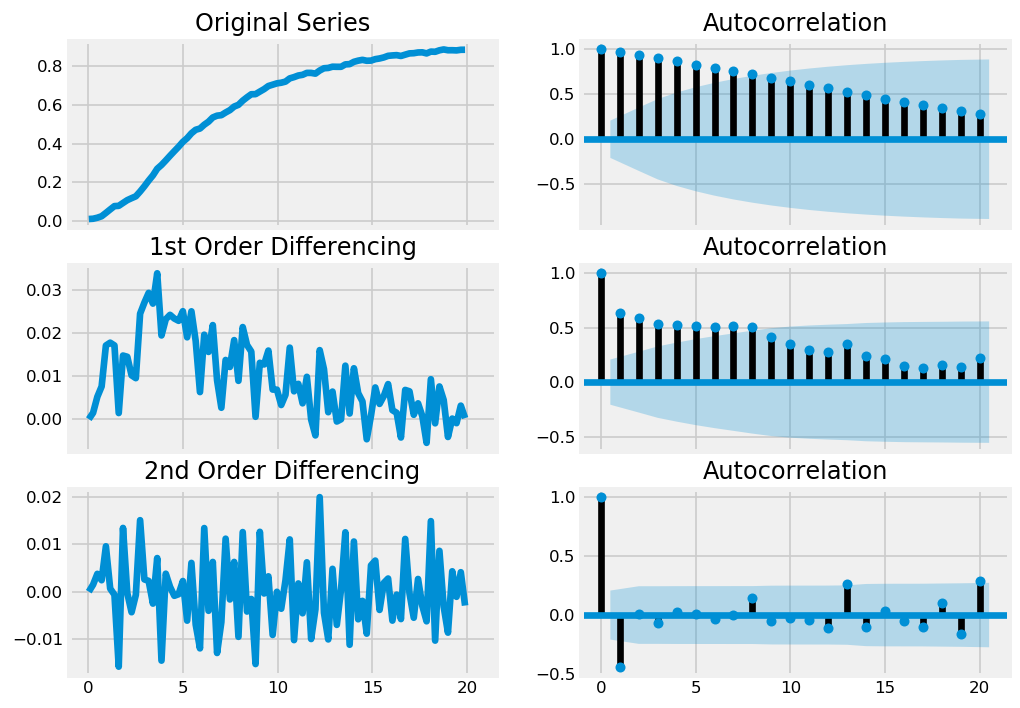

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])
# 1st Differencing
dff=df.diff(axis=0).fillna(0)
axes[1, 0].plot(dff); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dff, ax=axes[1, 1])
# 2nd Differencing
dfff=dff.diff(axis=0).fillna(0)
axes[2, 0].plot(dfff); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dfff, ax=axes[2, 1])

plt.show()

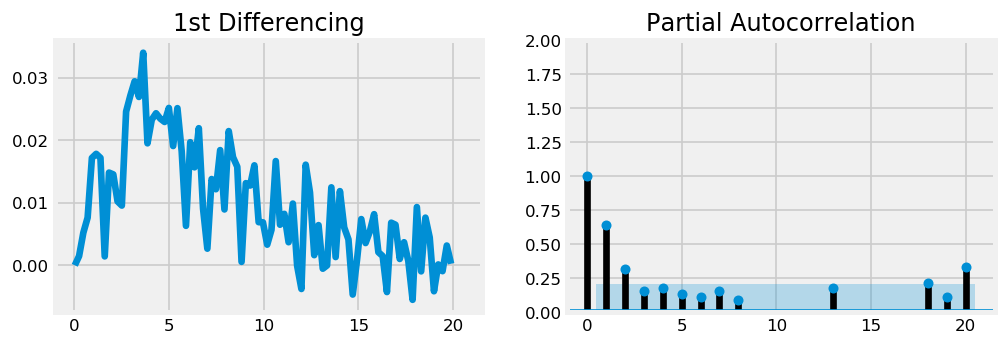

In [4]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(dff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
plot_pacf(dff, ax=axes[1])
plt.show()

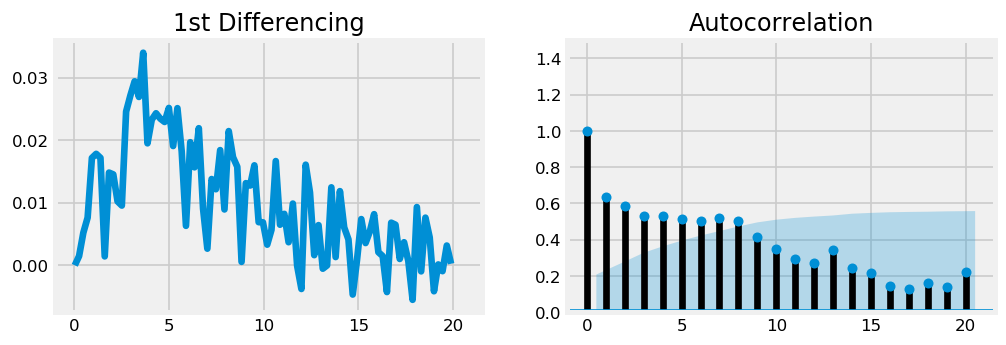

In [5]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(dff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.5))
plot_acf(dff, ax=axes[1])
plt.show()

In [7]:
from statsmodels.tsa.arima_model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(df, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\gjieqing\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\gjieqing\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.Mixing index   No. Observations:                   88
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 320.493
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 20 May 2020   AIC                           -630.986
Time:                        15:41:44   BIC                           -618.600
Sample:                             1   HQIC                          -625.996
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0081      0.004      1.802      0.075      -0.001       0.017
ar.L1.D.Mixing index     0.9598      0.033     29.210      0.000       0.895       1.024
ma.L1.D.Mixi

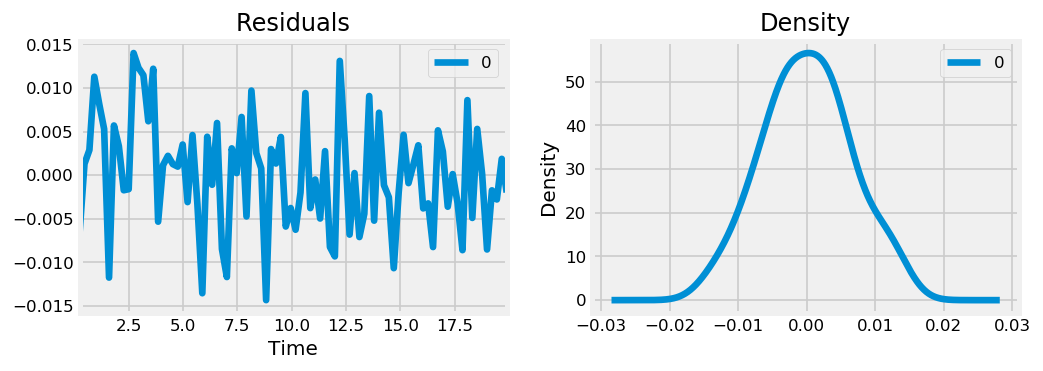

In [8]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

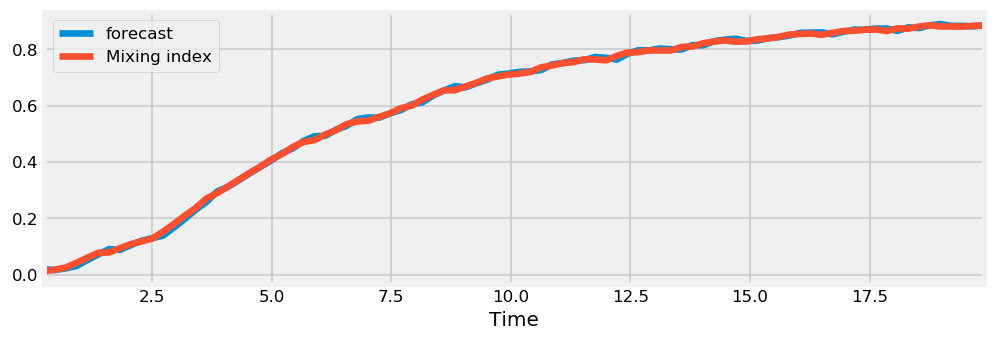

In [9]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [43]:
from statsmodels.tsa.stattools import acf
# Create Training and Test
train = df[:12]
test = df[12:]
print(test.shape)

(35, 1)


C:\Users\gjieqing\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\gjieqing\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D2.Mixing index   No. Observations:                   52
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 184.736
Method:                       css-mle   S.D. of innovations              0.007
Date:                Wed, 20 May 2020   AIC                           -359.472
Time:                        16:00:14   BIC                           -349.716
Sample:                             2   HQIC                          -355.732
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0002      0.000     -0.929      0.357      -0.001       0.000
ar.L1.D2.Mixing index     0.4714      0.142      3.326      0.002       0.194       0.749
ar.L2.D2

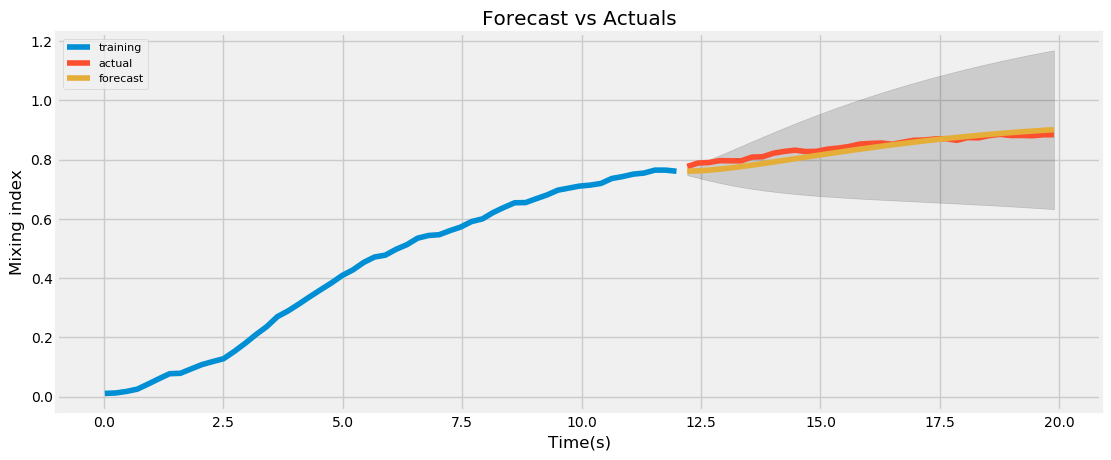

In [44]:
# Build Model
model = ARIMA(train, order=(2, 2, 1))
fitted = model.fit(disp=0)
print(fitted.summary())
# Forecast
fc, se, conf = fitted.forecast(35,alpha=0.05) # 95% conf
print(fc.ndim)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series,
color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xlabel('Time(s)')
plt.ylabel('Mixing index')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual)/actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5 # RMSE
    corr = np.corrcoef(forecast, actual)[0,1] # corr
    mins = np.amin(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs) # minmax
    acf1 = acf(forecast - actual)[1] # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test['Mixing index'])